In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df = pd.read_csv("AEP_hourly.csv", parse_dates=["Datetime"])

df = df.sort_values("Datetime")
df = df.set_index("Datetime")

df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   load    121273 non-null  int64
dtypes: int64(1)
memory usage: 1.9 MB


/tmp/ipython-input-1250875581.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("AEP_hourly.csv", parse_dates=["Datetime"])


(                      load
 Datetime                  
 2004-10-01 01:00:00  12379
 2004-10-01 02:00:00  11935
 2004-10-01 03:00:00  11692
 2004-10-01 04:00:00  11597
 2004-10-01 05:00:00  11681,
 None)

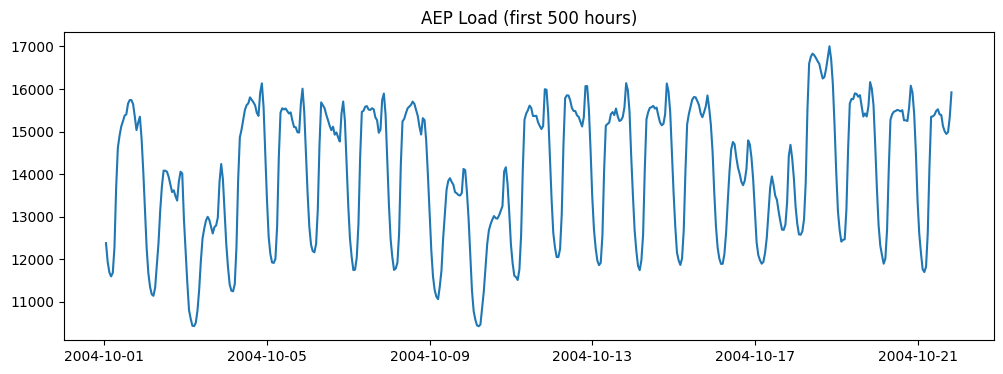

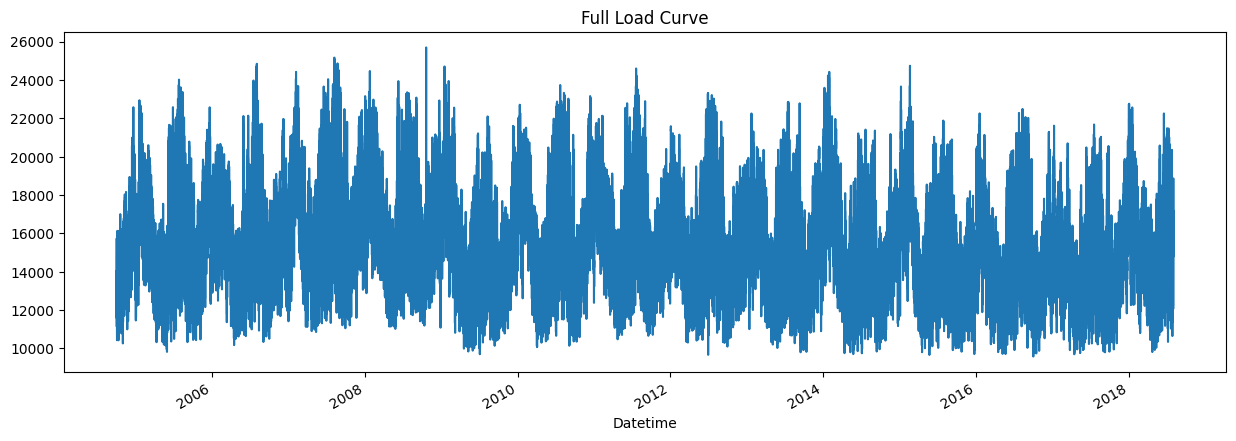

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df["load"].iloc[:500])
plt.title("AEP Load (first 500 hours)")
plt.show()

df["load"].plot(figsize=(15,5), title="Full Load Curve")
plt.show()


In [ ]:
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

df["lag_1"] = df["load"].shift(1)
df["lag_24"] = df["load"].shift(24)
df["lag_168"] = df["load"].shift(168)

df["rolling_24"] = df["load"].shift(1).rolling(24).mean()
df["rolling_168"] = df["load"].shift(1).rolling(168).mean()

df = df.dropna()

df.head()


,load,hour,dayofweek,month,is_weekend,lag_1,lag_24,lag_168,rolling_24,rolling_168
Datetime,,,,,,,,,,
2004-10-08 01:00:00,12468,1,4,10,0,13271.0,12484.0,12379.0,14450.333333,13870.315476
2004-10-08 02:00:00,12046,2,4,10,0,12468.0,12054.0,11935.0,14449.666667,13870.845238
2004-10-08 03:00:00,11749,3,4,10,0,12046.0,11745.0,11692.0,14449.333333,13871.505952
2004-10-08 04:00:00,11784,4,4,10,0,11749.0,11757.0,11597.0,14449.500000,13871.845238
2004-10-08 05:00:00,11919,5,4,10,0,11784.0,12041.0,11681.0,14450.625000,13872.958333


In [ ]:
test_size = 24 * 14
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

X_train = train.drop("load", axis=1)
y_train = train["load"]

X_test = test.drop("load", axis=1)
y_test = test["load"]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

baseline_pred = test["lag_24"]

mae_base = mean_absolute_error(y_test, baseline_pred)
rmse_base = np.sqrt(mean_squared_error(y_test, baseline_pred))  # <- updated

print("Baseline MAE:", mae_base)
print("Baseline RMSE:", rmse_base)


Baseline MAE: 903.6309523809524
Baseline RMSE: 1209.6078073570159


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=40,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

print("RF MAE:", mae_rf)
print("RF RMSE:", rmse_rf)


RF MAE: 157.44108306916215
RF RMSE: 210.08121252573036


In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train len:", len(y_train))
print("y_test len:", len(y_test))


X_train shape: (120769, 9)
X_test shape: (336, 9)
y_train len: 120769
y_test len: 336


In [ ]:
import joblib

joblib.dump(rf, "rf_model.pkl")
print("Model saved as rf_model.pkl")


Model saved as rf_model.pkl


In [ ]:
!pip install ipywidgets
from google.colab import output
output.enable_custom_widget_manager()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.4 MB/s eta 0:00:00


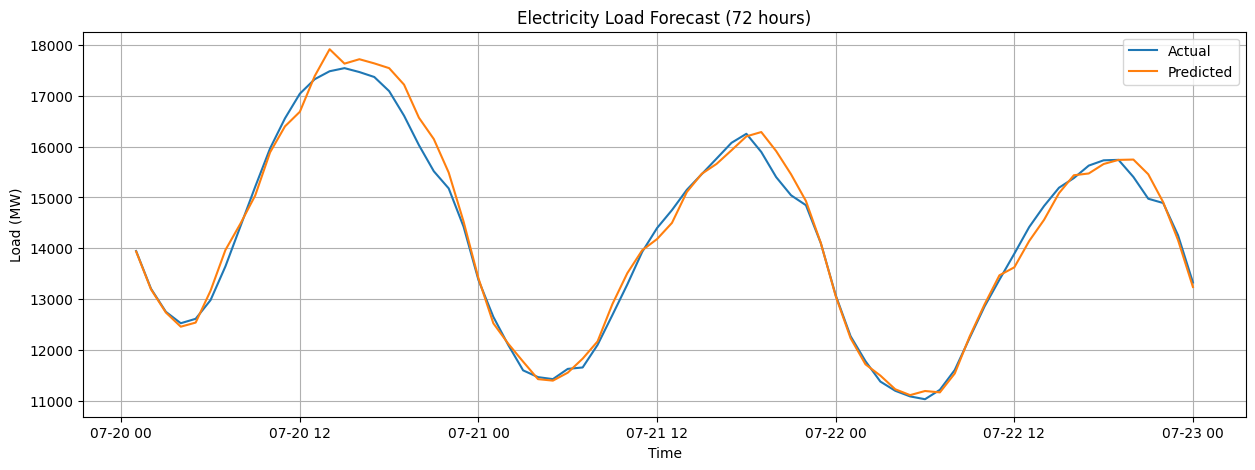

===== Model Performance =====
MAE  : 161.44
RMSE : 225.50


In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

hours_slider = widgets.IntSlider(
    value=168,
    min=24,
    max=336,
    step=24,
    description='Hours:',
    continuous_update=False
)

run_button = widgets.Button(
    description='Run Forecast',
    button_style='success'
)

output_area = widgets.Output()

def run_forecast(b):
    with output_area:
        output_area.clear_output()

        hours = hours_slider.value

        pred_rf = rf.predict(X_test)

        plt.figure(figsize=(15, 5))
        plt.plot(y_test.index[:hours], y_test.values[:hours], label="Actual")
        plt.plot(y_test.index[:hours], pred_rf[:hours], label="Predicted")
        plt.title(f"Electricity Load Forecast ({hours} hours)")
        plt.xlabel("Time")
        plt.ylabel("Load (MW)")
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = np.mean(np.abs(y_test[:hours] - pred_rf[:hours]))
        rmse = np.sqrt(np.mean((y_test[:hours] - pred_rf[:hours])**2))

        print("===== Model Performance =====")
        print(f"MAE  : {mae:.2f}")
        print(f"RMSE : {rmse:.2f}")

run_button.on_click(run_forecast)

widgets.VBox([
    widgets.HTML("<h2>⚡ Electricity Demand Forecasting UI</h2>"),
    hours_slider,
    run_button,
    output_area
])
